In [1]:
using Optimisers, Zygote, Plots, Random, Distributions

In [2]:
SEED = 42
N_collocation_points = 50
HIDDEN_DEPTH = 100
LEARNING_RATE = 1e-3
N_EPOCHS = 20_000
BC_LOSS_WEIGHT = 100.0

100.0

In [3]:
rhs_function(x) = sin(π * x)
analytical_solution(x) = sin(π * x) / π^2
rng = MersenneTwister(SEED)
sigmoid(x) = 1.0 / (1.0 + exp(-x))

sigmoid (generic function with 1 method)

In [4]:
# Initialize the weights according to the Xavier Glorot initializer. This initializer is commonly used to prevent the gradients from vanishing or exploding during training
uniform_limit = sqrt(6 / (1 + HIDDEN_DEPTH))
W = rand(
    rng,
    Uniform(-uniform_limit, +uniform_limit),
    HIDDEN_DEPTH,
    1,
)

# Initialize the transpo matrix to match the dimensions
V = rand(
    rng,
    Uniform(-uniform_limit, +uniform_limit),
    1,
    HIDDEN_DEPTH,
)

# Initialize the bias
b = zeros(HIDDEN_DEPTH);

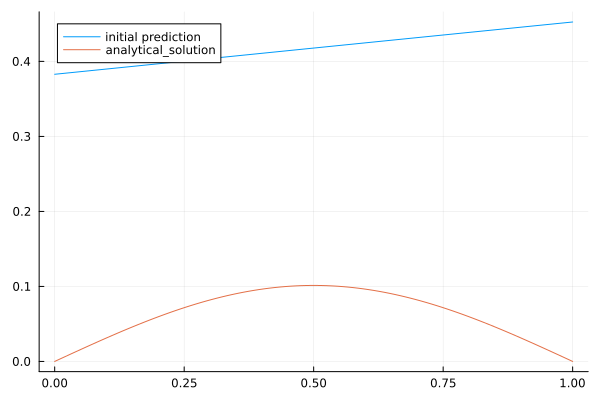

In [5]:
#Parameters definition
parameters = (; W, V, b);

#Definition of the network and the space
network_forward(x, p) = p.V * sigmoid.(p.W * x .+ p.b)
x_line = reshape(collect(range(0.0, stop=1.0, length=100)), (1, 100))

# Ploting the initial prediction of the network and the analytical solution
plot(x_line[:], network_forward(x_line, parameters)[:], label="initial prediction")
plot!(x_line[:], analytical_solution.(x_line[:]), label="analytical_solution")

In [6]:
#Manual differentiation of the network
function network_output_and_first_two_derivatives(x, p)
    activated_state = sigmoid.(p.W * x .+ p.b)
    sigmoid_prime = activated_state .* (1.0 .- activated_state)
    sigmoid_double_prime = sigmoid_prime .* (1.0 .- 2.0 .* activated_state)

    output = p.V * activated_state
    first_derivative = (p.V .* p.W') * sigmoid_prime
    second_derivative = (p.V .* p.W' .* p.W') * sigmoid_double_prime

    return output, first_derivative, second_derivative
end

network_output_and_first_two_derivatives (generic function with 1 method)

In [7]:
_output, _first_derivative, _second_derivative = network_output_and_first_two_derivatives(x_line, parameters)

([0.38282994071528714 0.3835365359378942 … 0.4518323843431763 0.45253146349204787], [0.06995295282877508 0.06995287545697229 … 0.06921631175116728 0.06920133527345308], [0.0 -1.531960301644129e-5 … -0.0014754077309355313 -0.0014899322179842476])

In [8]:
_first_derivative

1×100 Matrix{Float64}:
 0.069953  0.0699529  0.0699526  …  0.0692311  0.0692163  0.0692013

In [9]:
_second_derivative

1×100 Matrix{Float64}:
 0.0  -1.53196e-5  -3.0639e-5  -4.59581e-5  …  -0.00147541  -0.00148993

In [10]:
_zygote_first_derivative = Zygote.gradient(x -> sum(network_forward(x, parameters)), x_line)[1]

1×100 Matrix{Float64}:
 0.069953  0.0699529  0.0699526  …  0.0692311  0.0692163  0.0692013

In [22]:
interior_collocation_points = rand(rng, Uniform(0.0, 1.0), (1, N_collocation_points))
boundary_collocation_points = [0.0 1.0]

function loss_forward(p)
    output, first_derivative, second_derivative = network_output_and_first_two_derivatives(interior_collocation_points, p,)

    interior_residuals = second_derivative .+ rhs_function.(interior_collocation_points)
    interior_loss = 0.5 * mean(interior_residuals.^2)
    boundary_residuals = network_forward(boundary_collocation_points, p) .- 0.0
    boundary_loss = 0.5 * mean(boundary_residuals.^2)
    total_loss = interior_loss + BC_LOSS_WEIGHT * boundary_loss

    return total_loss
end

loss_forward (generic function with 1 method)

In [23]:
loss_forward(parameters)

0.01256500236145388

In [24]:
loss_forward(parameters)
out, back = Zygote.pullback(loss_forward, parameters)

(0.01256500236145388, Zygote.var"#75#76"{Zygote.Pullback{Tuple{typeof(loss_forward), @NamedTuple{W::Matrix{Float64}, V::Matrix{Float64}, b::Vector{Float64}}}, Tuple{Zygote.var"#1986#back#194"{Zygote.var"#190#193"{Zygote.Context{false}, GlobalRef, Float64}}, Zygote.var"#3876#back#1241"{Zygote.var"#1237#1240"{2, Matrix{Float64}}}, Zygote.var"#1922#back#161"{Zygote.var"#157#160"}, Zygote.var"#1986#back#194"{Zygote.var"#190#193"{Zygote.Context{false}, GlobalRef, Matrix{Float64}}}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), Matrix{Float64}}, Tuple{}}, Zygote.var"#1986#back#194"{Zygote.var"#190#193"{Zygote.Context{false}, GlobalRef, Matrix{Float64}}}, Zygote.var"#2029#back#213"{Zygote.var"#back#211"{2, 2, Zygote.Context{false}, Int64}}, Zygote.var"#2029#back#213"{Zygote.var"#back#211"{2, 1, Zygote.Context{false}, Matrix{Float64}}}, Zygote.ZBack{ChainRules.var"#times_pullback2#1329"{Float64, Float64}}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), Matrix{Float64}}, 

In [25]:
back(1.0)[1]

(W = [-0.00020598258153910393; -0.00023450955993711017; … ; 6.472247924448708e-5; 6.419863949513141e-5;;], V = [0.00011257003318888313 9.17332761905256e-5 … -0.00017571386539557367 2.998593385122872e-6], b = [-6.509489102869989e-5, -7.364530874855613e-5, 0.00032782059459391224, 2.067160242870561e-5, 3.731325759696842e-5, 0.00013526329957654998, -3.7746456578871106e-5, -3.3759440850198137e-6, -9.266848762197505e-5, -8.973460418245669e-5  …  5.384574480560089e-7, 6.133467772300483e-8, 2.0069495118428485e-5, 6.534213651231831e-5, 1.4043329088688582e-6, -1.626863164349447e-6, 3.366308459125685e-5, -4.241898782763802e-5, 2.023393953746217e-5, 2.231998878520396e-5])

In [26]:
opt = Adam(LEARNING_RATE)
opt_state = Optimisers.setup(opt, parameters)
loss_history = []
for i in 1:N_EPOCHS
    loss, back = Zygote.pullback(loss_forward, parameters)
    push!(loss_history, loss)
    grad, = back(1.0)
    opt_state, parameters = Optimisers.update(opt_state, parameters, grad)
    if i % 100 == 0
        println("Epoch: $i, Loss: $loss")
    end
end

Epoch: 100, Loss: 0.011902589568194346
Epoch: 200, Loss: 0.011164718452744957
Epoch: 300, Loss: 0.010393847877341964
Epoch: 400, Loss: 0.009642367124824757
Epoch: 500, Loss: 0.008966008085237157
Epoch: 600, Loss: 0.008401120077823244
Epoch: 700, Loss: 0.007959224968626074
Epoch: 800, Loss: 0.0076306106843808145
Epoch: 900, Loss: 0.007392850536079342
Epoch: 1000, Loss: 0.008132766422402179
Epoch: 1100, Loss: 0.007124969325407556
Epoch: 1200, Loss: 0.007038521149505671
Epoch: 1300, Loss: 0.006960874617024238
Epoch: 1400, Loss: 0.00688801063619325
Epoch: 1500, Loss: 0.006817335431598234
Epoch: 1600, Loss: 0.006761187805400736
Epoch: 1700, Loss: 0.006701584551197673
Epoch: 1800, Loss: 0.006645957309638869
Epoch: 1900, Loss: 0.006588828517897396
Epoch: 2000, Loss: 0.006529714800267142
Epoch: 2100, Loss: 0.006474466340105992
Epoch: 2200, Loss: 0.006423178147081133
Epoch: 2300, Loss: 0.006370593942396205
Epoch: 2400, Loss: 0.006314775245329398
Epoch: 2500, Loss: 0.006255139104963805
Epoch: 26

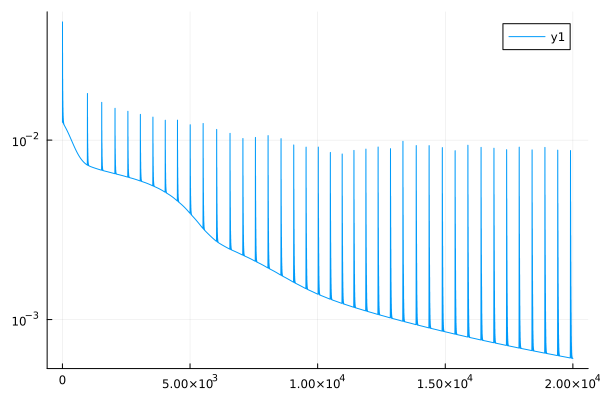

In [27]:
plot(loss_history, yscale=:log10)

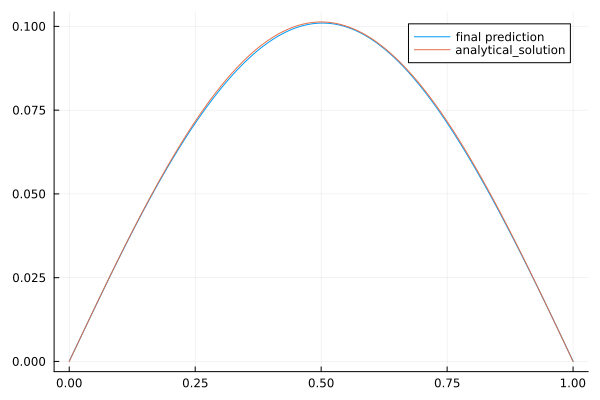

In [28]:
plot(x_line[:], network_forward(x_line, parameters)[:], label="final prediction")
plot!(x_line[:], analytical_solution.(x_line[:]), label="analytical_solution")